# Randoms

Here I compute the randoms for the mock catalogs.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
#!/usr/bin/env python
import os
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import matplotlib
matplotlib.rc('xtick', labelsize=20, top=True, direction='in')
matplotlib.rc('ytick', labelsize=20, right=True, direction='in')
matplotlib.rc('axes', linewidth=1, labelsize=20)
matplotlib.rc('xtick.major', size=5)
#matplotlib.rc('xtick.minor', size=5)
matplotlib.rc('ytick.major', size=5)
#matplotlib.rc('ytick.minor', size=5)

In [4]:
# specify our cosmology
from astropy.cosmology import FlatLambdaCDM
cosmo0 = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)


In [5]:
from nbodykit.lab import *
from nbodykit import setup_logging, style

from scipy.interpolate import InterpolatedUnivariateSpline
plt.style.use(style.notebook)

In [6]:
import skymapper as skm

def plot_hpx_density(ra,dec, Npoints=10000, title=''):
    ix = np.random.randint(ra.size, size=Npoints)
    crit = skm.stdDistortion
    proj = skm.Albers.optimize(ra[ix], dec[ix], crit=crit)

    # construct map: will hold figure and projection
    # the outline of the sphere can be styled with kwargs for matplotlib Polygon
    map = skm.Map(proj)

    # add graticules, separated by 15 deg
    # the lines can be styled with kwargs for matplotlib Line2D
    # additional arguments for formatting the graticule labels
    sep=15
    map.grid(sep=sep)

    #### 1. plot density in healpix cells ####
    nside = 32
    mappable = map.density(ra, dec, nside=nside)
    cb = map.colorbar(mappable, cb_label="$n$ [arcmin$^{-2}$]")
    map.focus(ra[ix], dec[ix])
    map.title(title)
# example
# ra,dec = data['ra'],data['dec']
# plot_hpx_density(ra,dec)

In [7]:
import healpy as hp
def radec_to_pix(ra,dec,nside=4):
    thetas,phis = np.radians(90-dec),np.radians(ra)
    return hp.ang2pix(nside, thetas, phis,nest=False)

def makeHealpixMap(ra, dec, nside=1024, nest=False):
    # convert a ra/dec catalog into healpix map with counts per cell
    import healpy as hp
    ipix = hp.ang2pix(nside, (90-dec)/180*np.pi, ra/180*np.pi, nest=nest)
    return np.bincount(ipix, minlength=hp.nside2npix(nside))

In [8]:
# specify our cosmology
cosmo = cosmology.Cosmology(h=0.7).match(Omega0_m=0.3)


## Load Mock

In [9]:
import os
from astropy.table import Table
from astropy.io.fits import getdata
from fileLoc import FileLocs

floc = FileLocs(machine='nersc')
print('halo file name: %s'%floc.mock_nbody_fname)
data = Table(getdata(floc.mock_nbody_fname))
# data = FITSCatalog(floc.mock_nbody_fname)

halo file name: /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/mock_buzzard_like_y3_nbody.fits


In [10]:
# mock['redshift']

In [43]:
# if not os.path.isfile(floc.mock_nbody_fname):
mock = Table(getdata(floc.mock_nbody_fname))
data = Table(mock[['RA','DEC','redshift','lambda_mor']])

data.rename_columns(['RA','DEC','redshift'], ['ra','dec','z'])

select_good = (data['z']>=0.2) & (data['z']<=0.65)
select_good = select_good & ((data['z'] < 0.33)|(data['z'] > 0.37))
select_good&= data['lambda_mor']>=5.
ra = data['ra']
ix, = np.where(ra<0); ra[ix] = ra[ix]+360
data['ra'] = ra

data = data[select_good]
data.write(floc.mock_nbody_fname, overwrite=True)

In [12]:
np.array(data['ra'])

array([317.31292878, 307.15073025, 307.27470672, ...,  79.23189455,
        80.51872053,  79.88092463])

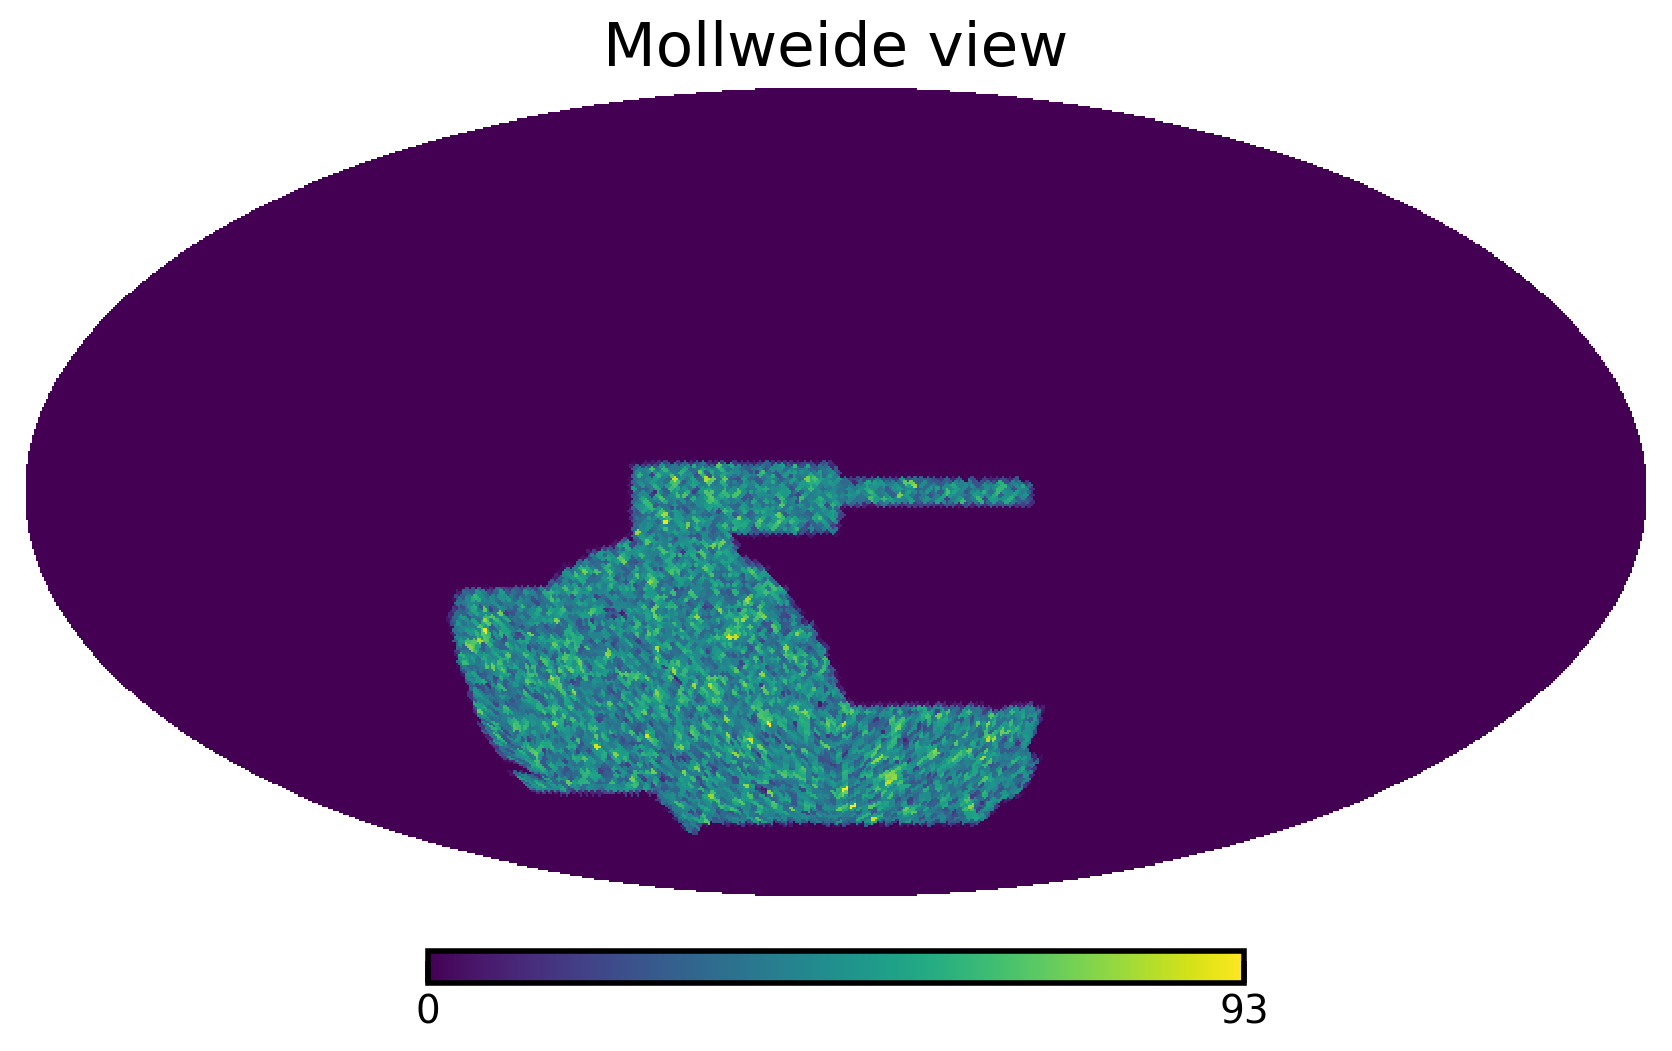

In [13]:
# mock healpix map
hpxmap = makeHealpixMap(data['ra'], data['dec'], nside=64)
hp.mollview(hpxmap)

# Generate Mock Randoms

To create uniform sky distributed objects you need to generate random number on the unit sphere. \
https://stackoverflow.com/questions/33976911/generate-a-random-sample-of-points-distributed-on-the-surface-of-a-unit-sphere

### Unit Sphere Random Number Generator

Uses polar coordinates then normalize by the norm of the vector to create an unit vector.


In [14]:
def sample_spherical(npoints, ndim=3):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return vec

Npoints = int(100*len(data))
xi, yi, zi = sample_spherical(Npoints)
pos = np.vstack([xi,yi,zi]).T

In [15]:
source = RandomCatalog(pos.shape[0], seed=42)
source['Position'] = source.make_column(pos)
source['Position']

dask.array<array, shape=(26362400, 3), dtype=float64, chunksize=(100000, 3), chunktype=numpy.ndarray>

In [16]:
from nbodykit.transform import CartesianToSky, CartesianToEquatorial

# project onto the sphere

_posSky = CartesianToEquatorial(source['Position'],observer=[0., 0., 0.], frame='icrs')
source['ra'] = np.where(_posSky[0]<0, _posSky[0]+360, _posSky[0])
source['dec'] = _posSky[1]

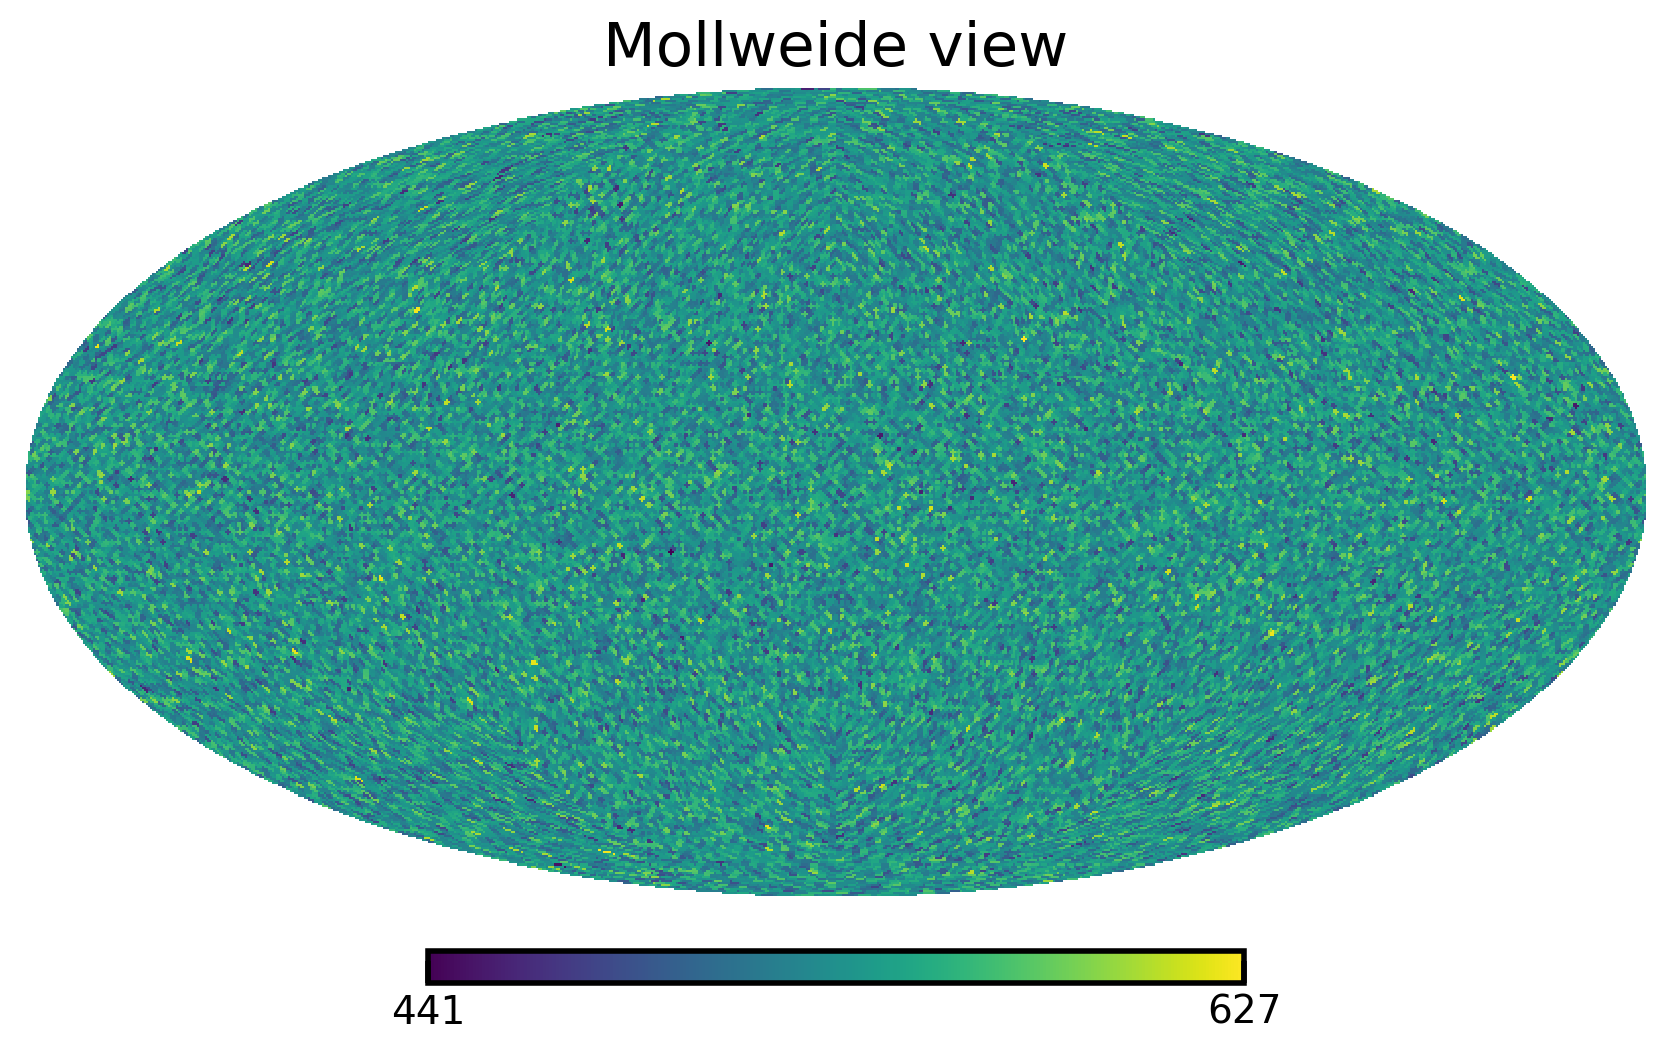

In [17]:
hm = makeHealpixMap(np.array(source['ra']), np.array(source['dec']),nside=64)
hp.mollview(hm)

In [18]:
hpx_coords = radec_to_pix(np.array(source['ra']), np.array(source['dec']),nside=64)
source['hpx_mask'] = (hpxmap[hpx_coords]!=0)

des_footprint = source['hpx_mask']
randoms = source[des_footprint]
randoms

RandomCatalog(size=3409178, seed=42)

optimizing parameters of Albers to minimize stdDistortion
best objective 0.047770 at Albers(24.64272245580841,-35.13799266371292,-58.148267955292816,-11.206144501613915)


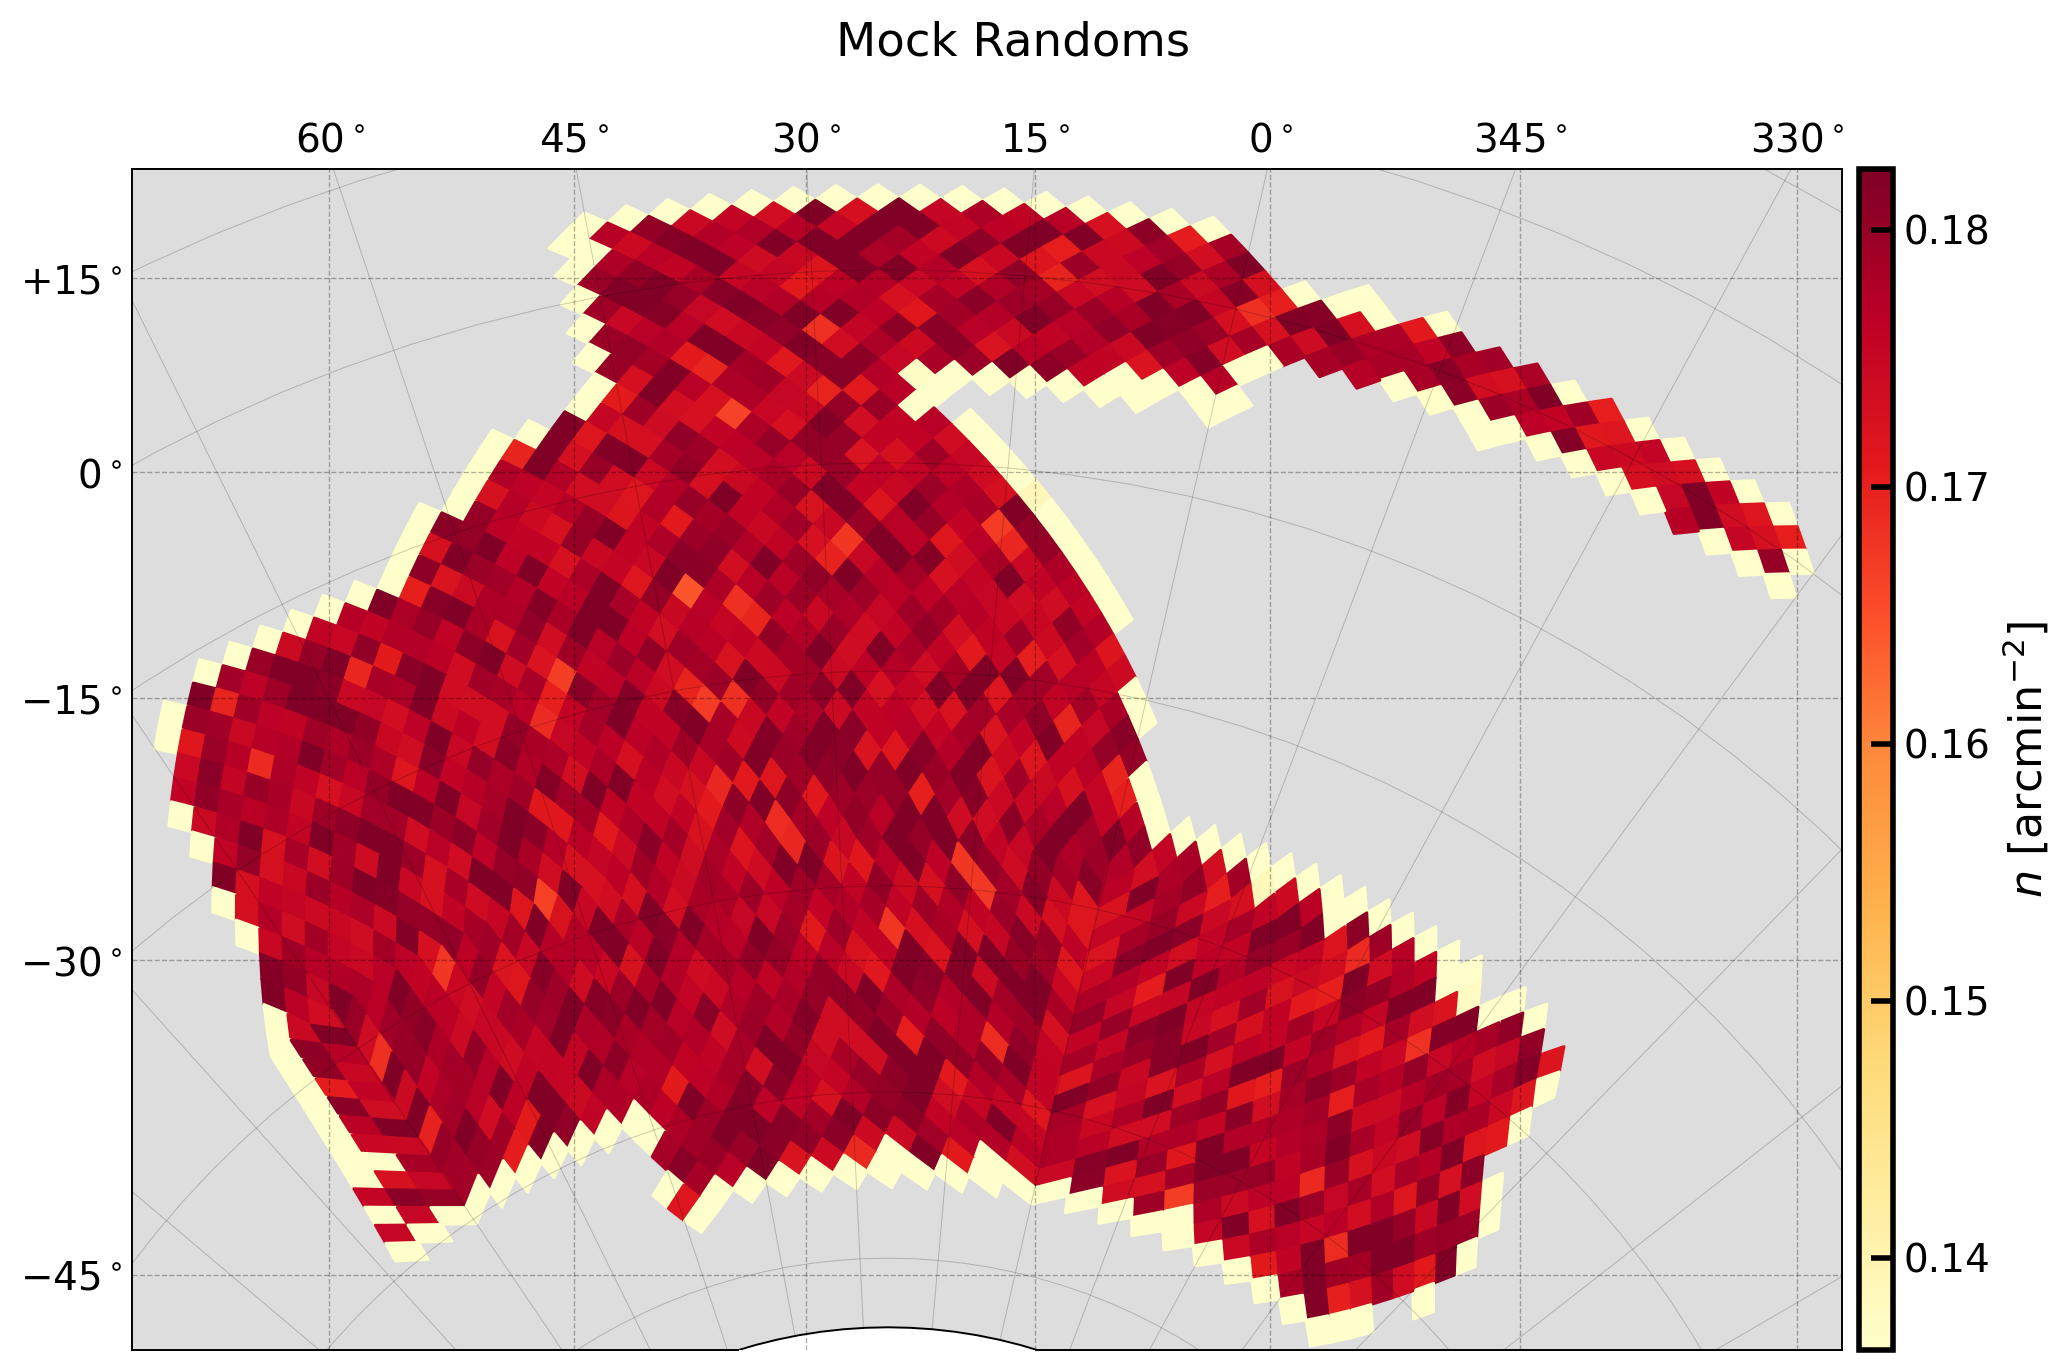

In [19]:
plot_hpx_density(np.array(randoms['ra']), np.array(randoms['dec']),title='Mock Randoms')


optimizing parameters of Albers to minimize stdDistortion
best objective 0.046681 at Albers(25.762828345995533,-35.23186027286075,-56.764580990710364,-11.121955484796858)


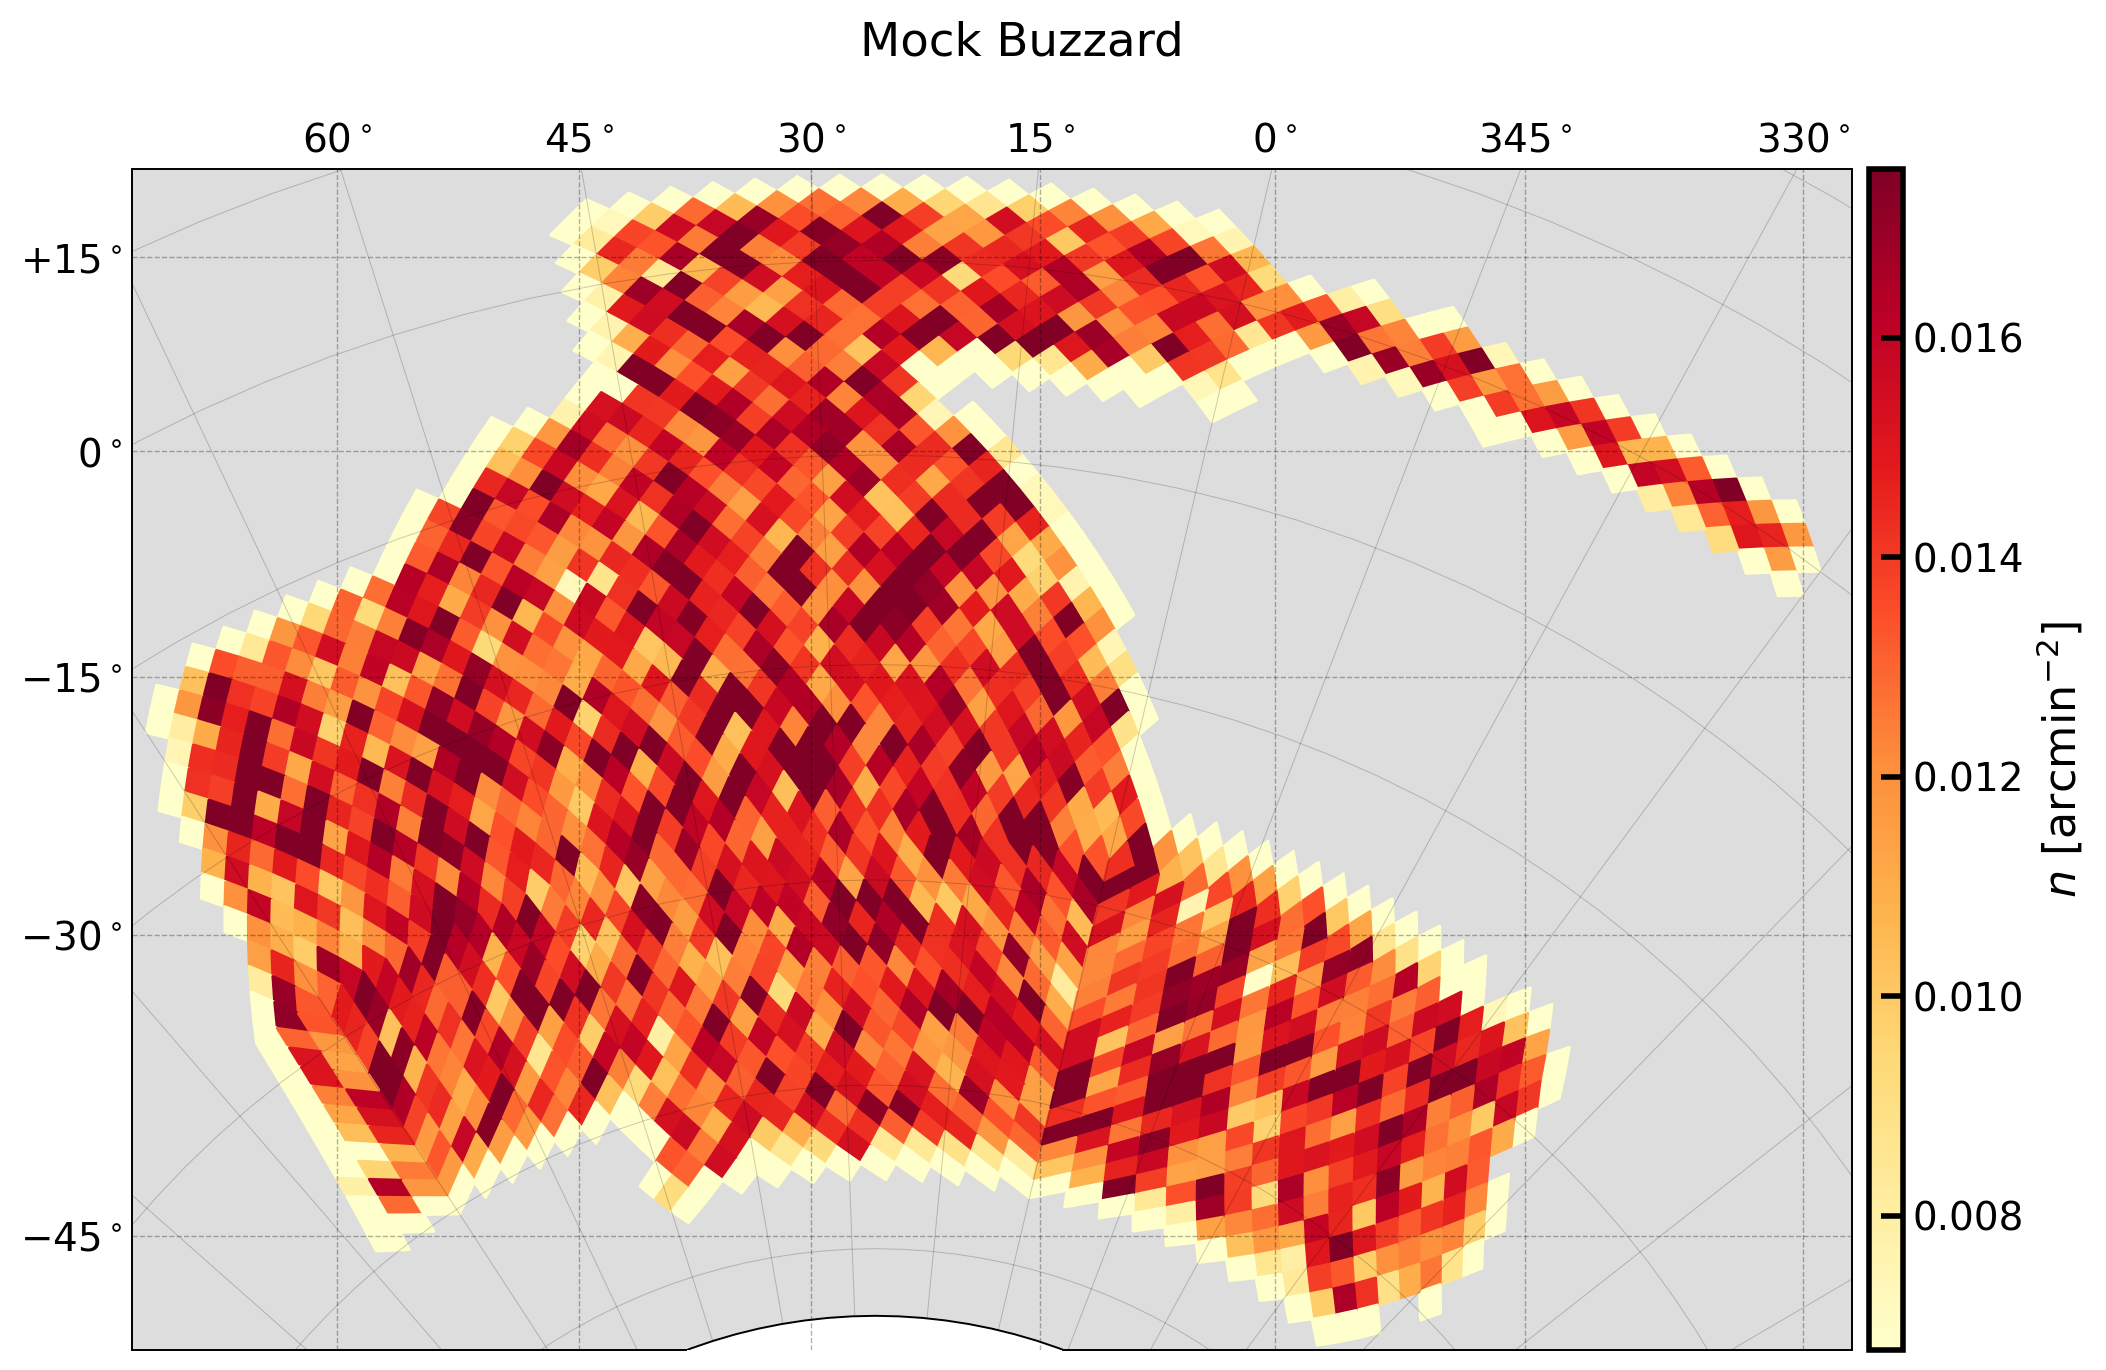

In [20]:
plot_hpx_density(np.array(data['ra']), np.array(data['dec']),title='Mock Buzzard')


## Survey Selection: $n(z)$

Now, I will paint a new redshift distribution on the mock.

In [21]:
FSKY = 1./8.
zbins = np.arange(0.18, 0.68, 0.0025)
zm   = zbins[:-1] + np.diff(zbins)
vbins = FSKY*(4/3.)*np.pi*((cosmo0.comoving_distance(zbins[1:])**3-cosmo0.comoving_distance(zbins[:-1])**3)).value
nz  = np.histogram(data['z'], bins=zbins)[0]#/vbins
nofz = InterpolatedUnivariateSpline(zm, nz)


In [22]:
alpha = 1.*len(data)/randoms.csize

zvec = np.random.uniform(0.2, 0.65, randoms.csize)
pz = nofz(zvec)
pz = np.where(pz<0., 0., pz)
# volume = comov_

# indices = np.arange(zvec.size,dtype=int)
znew = np.random.choice(zvec, p=pz/np.sum(pz), size=zvec.size)
znew = np.where((znew>0.33)&(znew<0.37), np.nan, znew)

# solving the nans
isnan = np.isnan(znew)
znew[isnan] = np.random.choice(zvec, p=pz/np.sum(pz), size=np.count_nonzero(isnan))

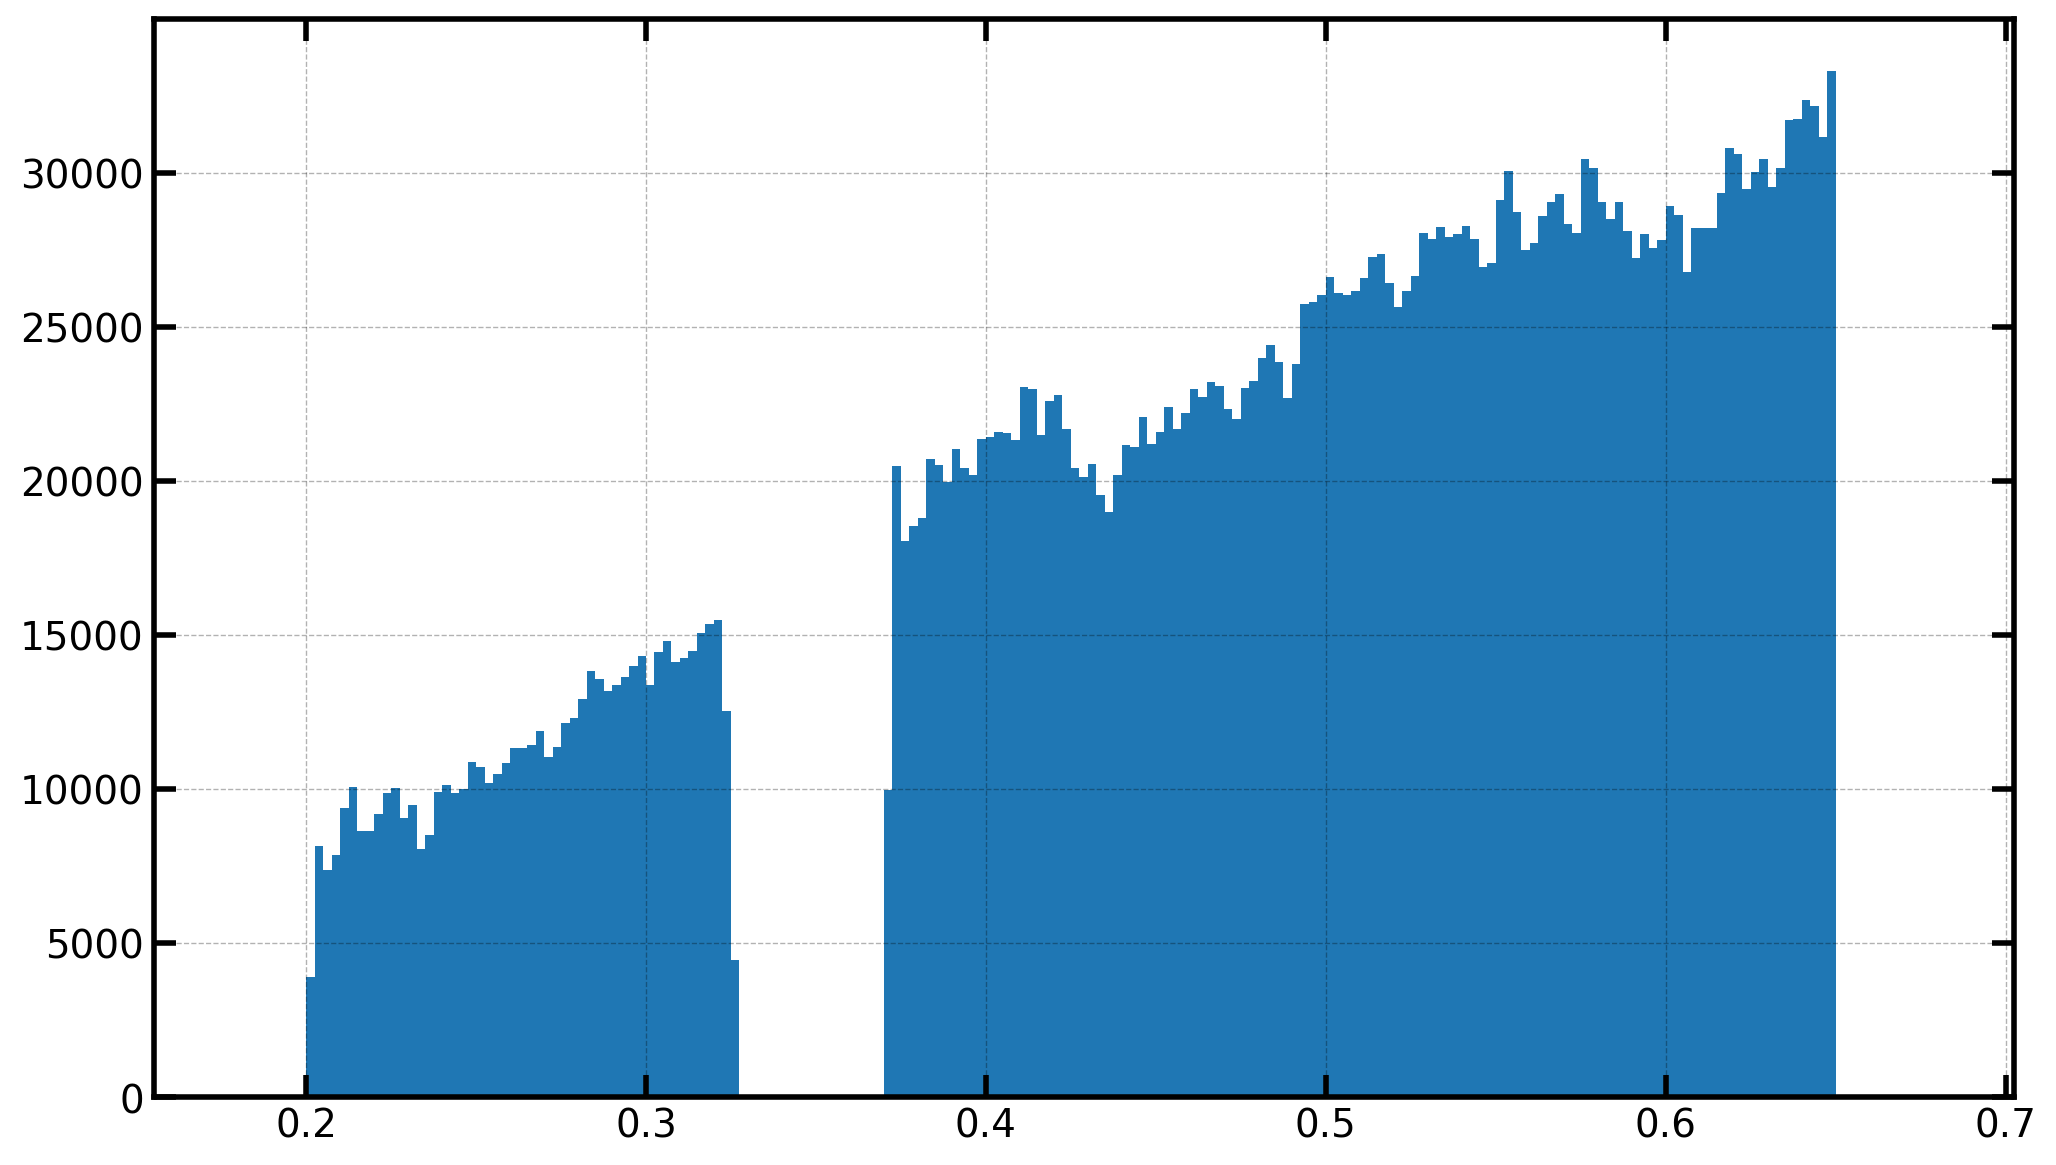

In [23]:
_ = plt.hist(znew, zbins)

In [24]:
randoms['z'] = znew

Text(0, 0.5, '$n(z)$ $[h^{3} \\mathrm{Mpc}^{-3}]$')

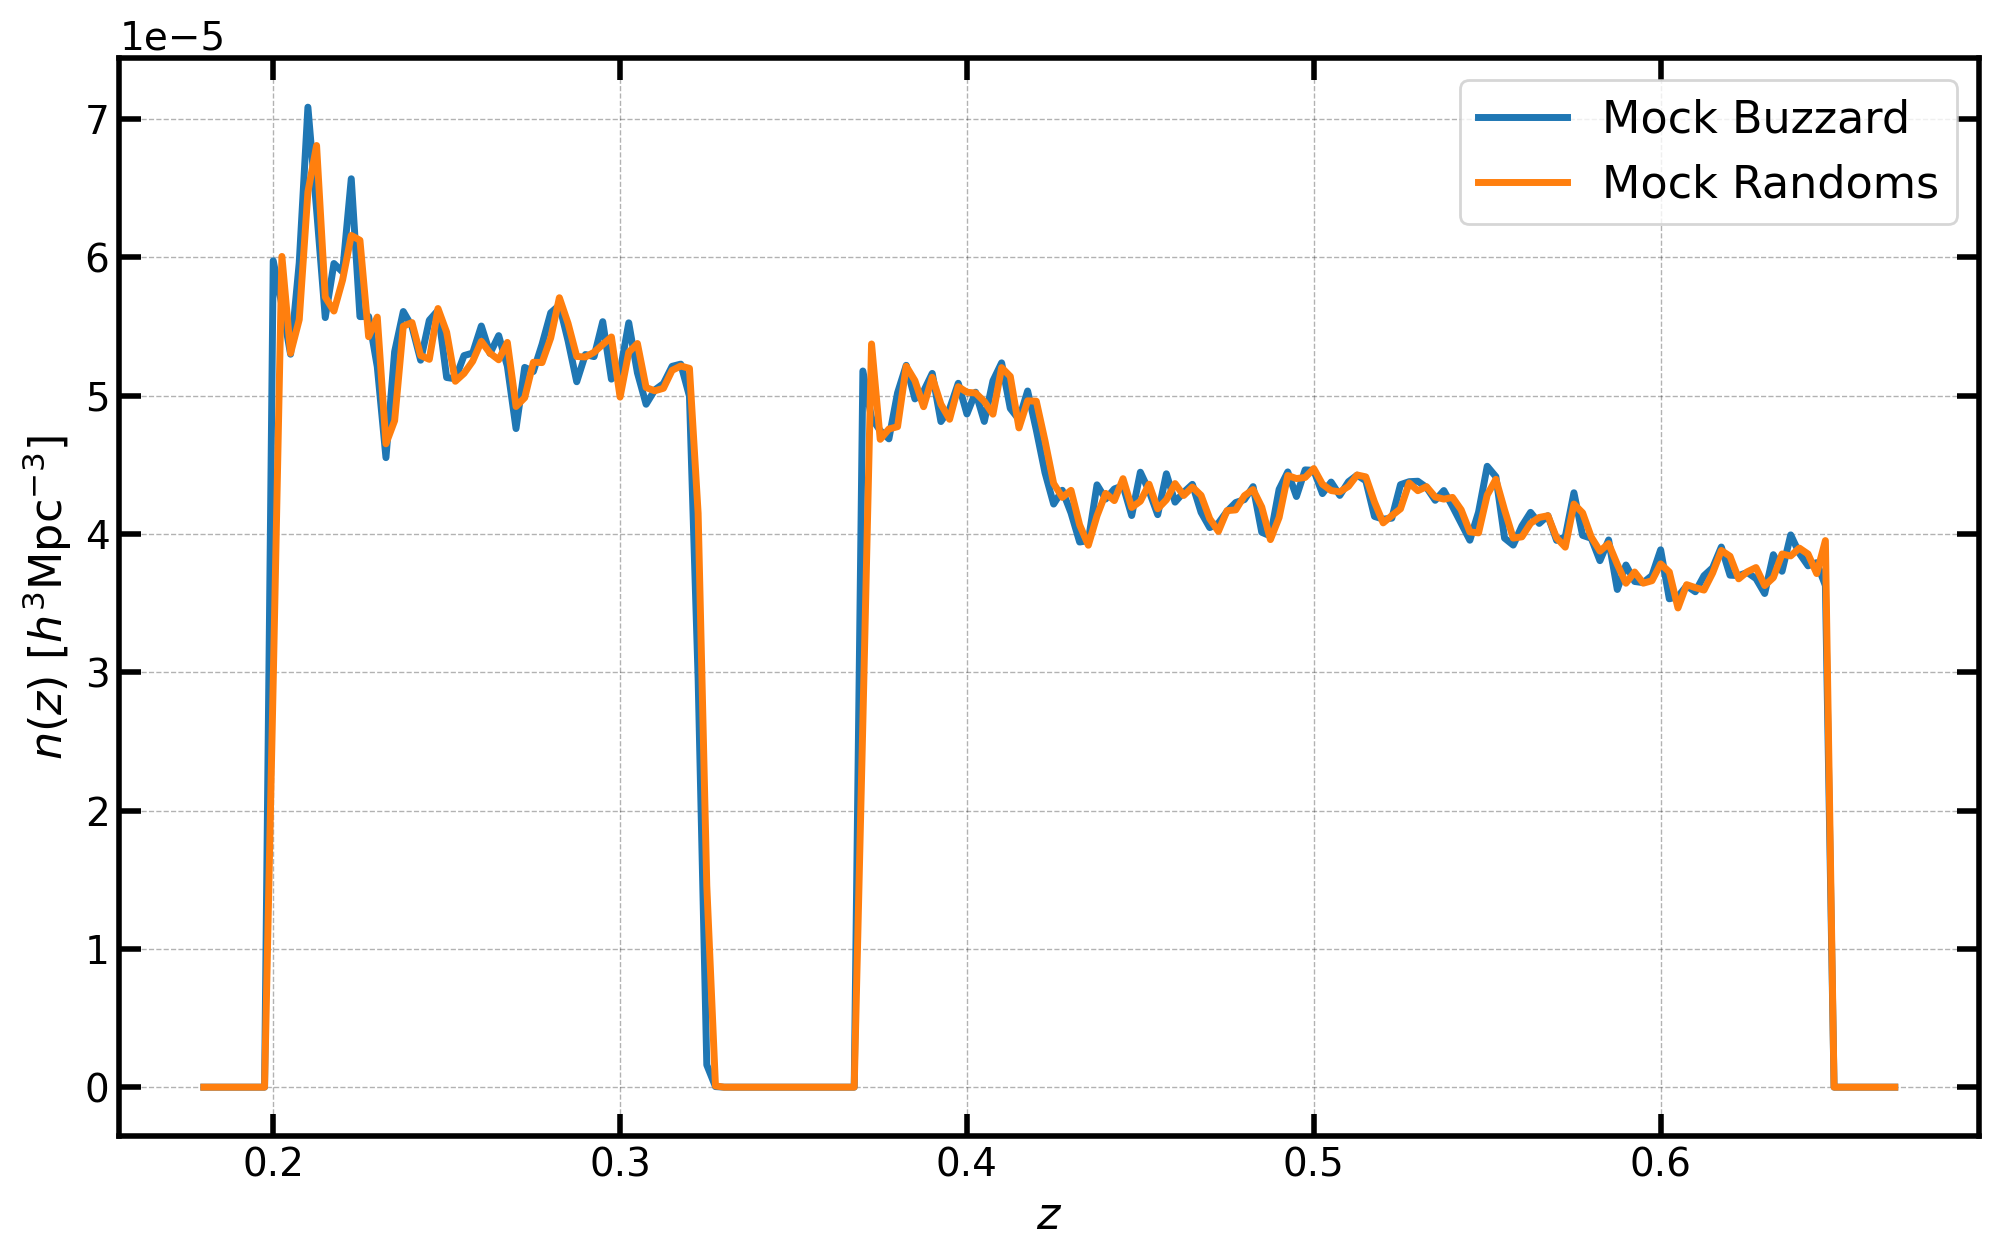

In [25]:
# The distributions need to match on the N(Z)/comoving volume
nz_ran  = np.histogram(np.array(randoms['z']), bins=zbins)[0]/vbins
nz  = np.histogram(data['z'], bins=zbins)[0]/vbins

w = np.where((zbins>=0.18)&(zbins<=0.67))[0]

# plot
plt.plot(zbins[w], nz[w], label='Mock Buzzard')
plt.plot(zbins[w], alpha*nz_ran[w], label='Mock Randoms')
plt.legend()
plt.xlabel(r"$z$", fontsize=16)
plt.ylabel(r"$n(z)$ $[h^{3} \mathrm{Mpc}^{-3}]$", fontsize=16)

Note: we should apply the survey area mask on the gaps of the halo catalog. Or fill the gaps on the randoms catalog.

## Lambda Distribution

In [26]:
lbd = np.array(data['lambda_mor'])
log_lbd = np.log10(lbd)
zcls = np.array(data['z'])
prob = nofz(zcls)
prob /= np.max(prob)

In [27]:
lbd

array([ 8.68199824, 10.06286253, 19.50773549, ...,  5.38995134,
        6.69582475,  5.5844871 ])

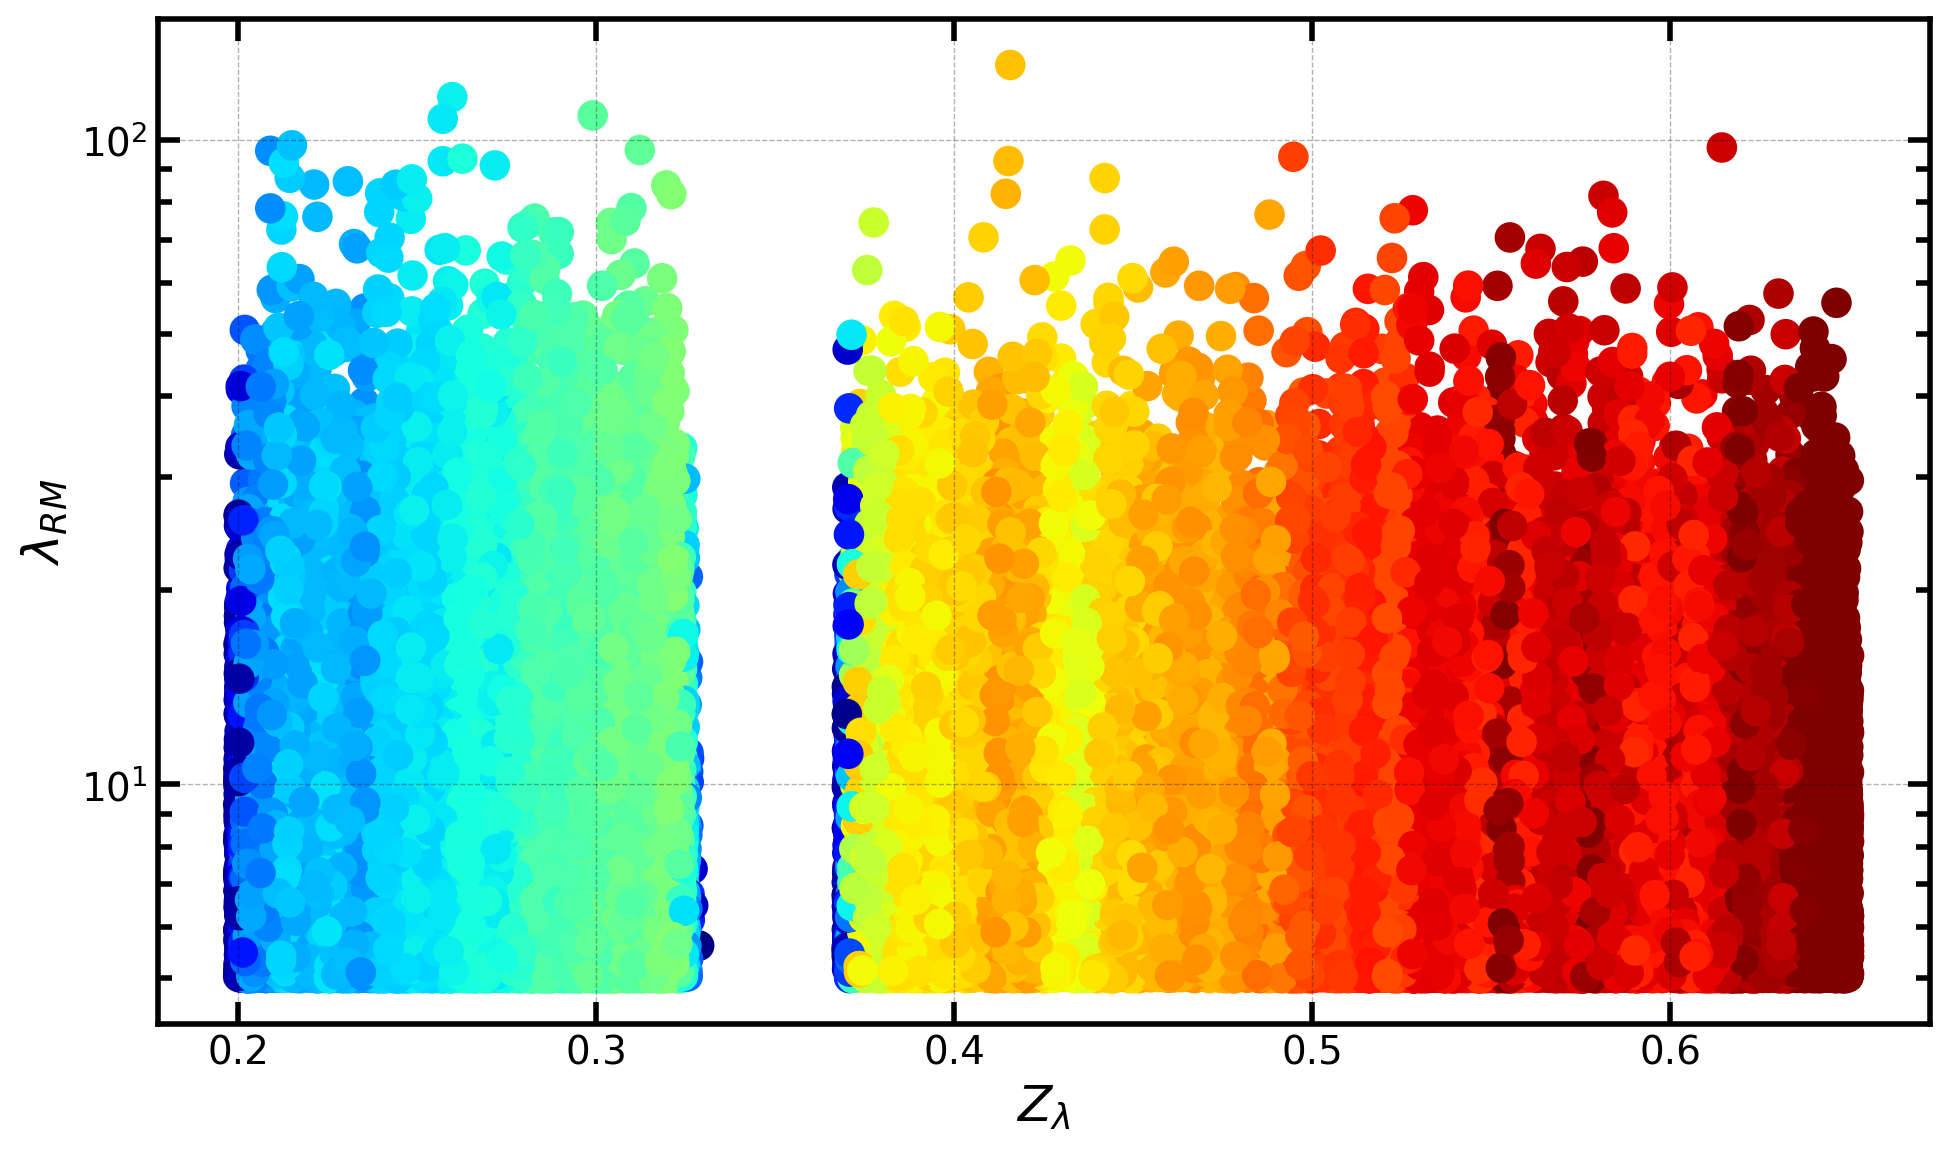

In [28]:
Np = 100000

plt.figure(figsize=(10,6))
idx = np.argsort(prob[np.random.randint(len(zcls), size=Np)])
plt.scatter(zcls[idx],lbd[idx],c=prob[idx],vmax=0.9,cmap='jet')
# plt.hexbin(zcls, lbd, yscale='log', gridsize=(50, 10))
# plt.xlabel(xlabel,fontsize=20)
# plt.ylabel(ylabel,fontsize=20)
# plt.colorbar().set_label('Probability',fontsize=14)
# plt.title('RM Y3 - Volume Limited',fontsize=20)
plt.yscale('log')
plt.ylabel(r'$\lambda_{RM}$', fontsize=18)
plt.xlabel(r'$Z_{\lambda}$', fontsize=18)
plt.tight_layout()
# plt.savefig('lambda_redshift_prob_sz.png',dpi=100, facecolor='w', transparent=False)

In [29]:
from sklearn.neighbors import KernelDensity

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x)
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid)
    return np.exp(log_pdf)

def std_vars(z,log_lbd):
    ## setup for standrized variables 
    zm = 0.479
    zstd = 0.12
    lm = 0.85
    lstd = 0.183
    z_norm = (z-zm)/zstd
    log_lbd_norm = (log_lbd-lm)/lstd
    return np.vstack([z_norm,log_lbd_norm]).T


In [30]:
Np = 500
# cut = np.random.randint(len(znew), size=Np)

log_lbd_ran = np.random.uniform(np.min(log_lbd), np.max(log_lbd), size=randoms.csize)
lbd_ran = 10**log_lbd_ran

log_lbd_vec = np.linspace(np.min(log_lbd), np.max(log_lbd), Np)
ll, zz = np.meshgrid(log_lbd_vec, zbins)

xgrid = std_vars(zz.flatten(), ll.flatten())
xnew = std_vars(znew, log_lbd_ran)
x = std_vars(zcls, log_lbd)

In [33]:
# building pdfs
# p = kde_sklearn(xgrid, xnew, bandwidth=0.05, rtol=1e-4) ## RM PDF(z,lambda) x Ncls_rm

p = kde_sklearn(x, xgrid, bandwidth=0.10, kernel='linear') ## RM PDF(z,lambda) x Ncls_rm
p/= np.max(p)

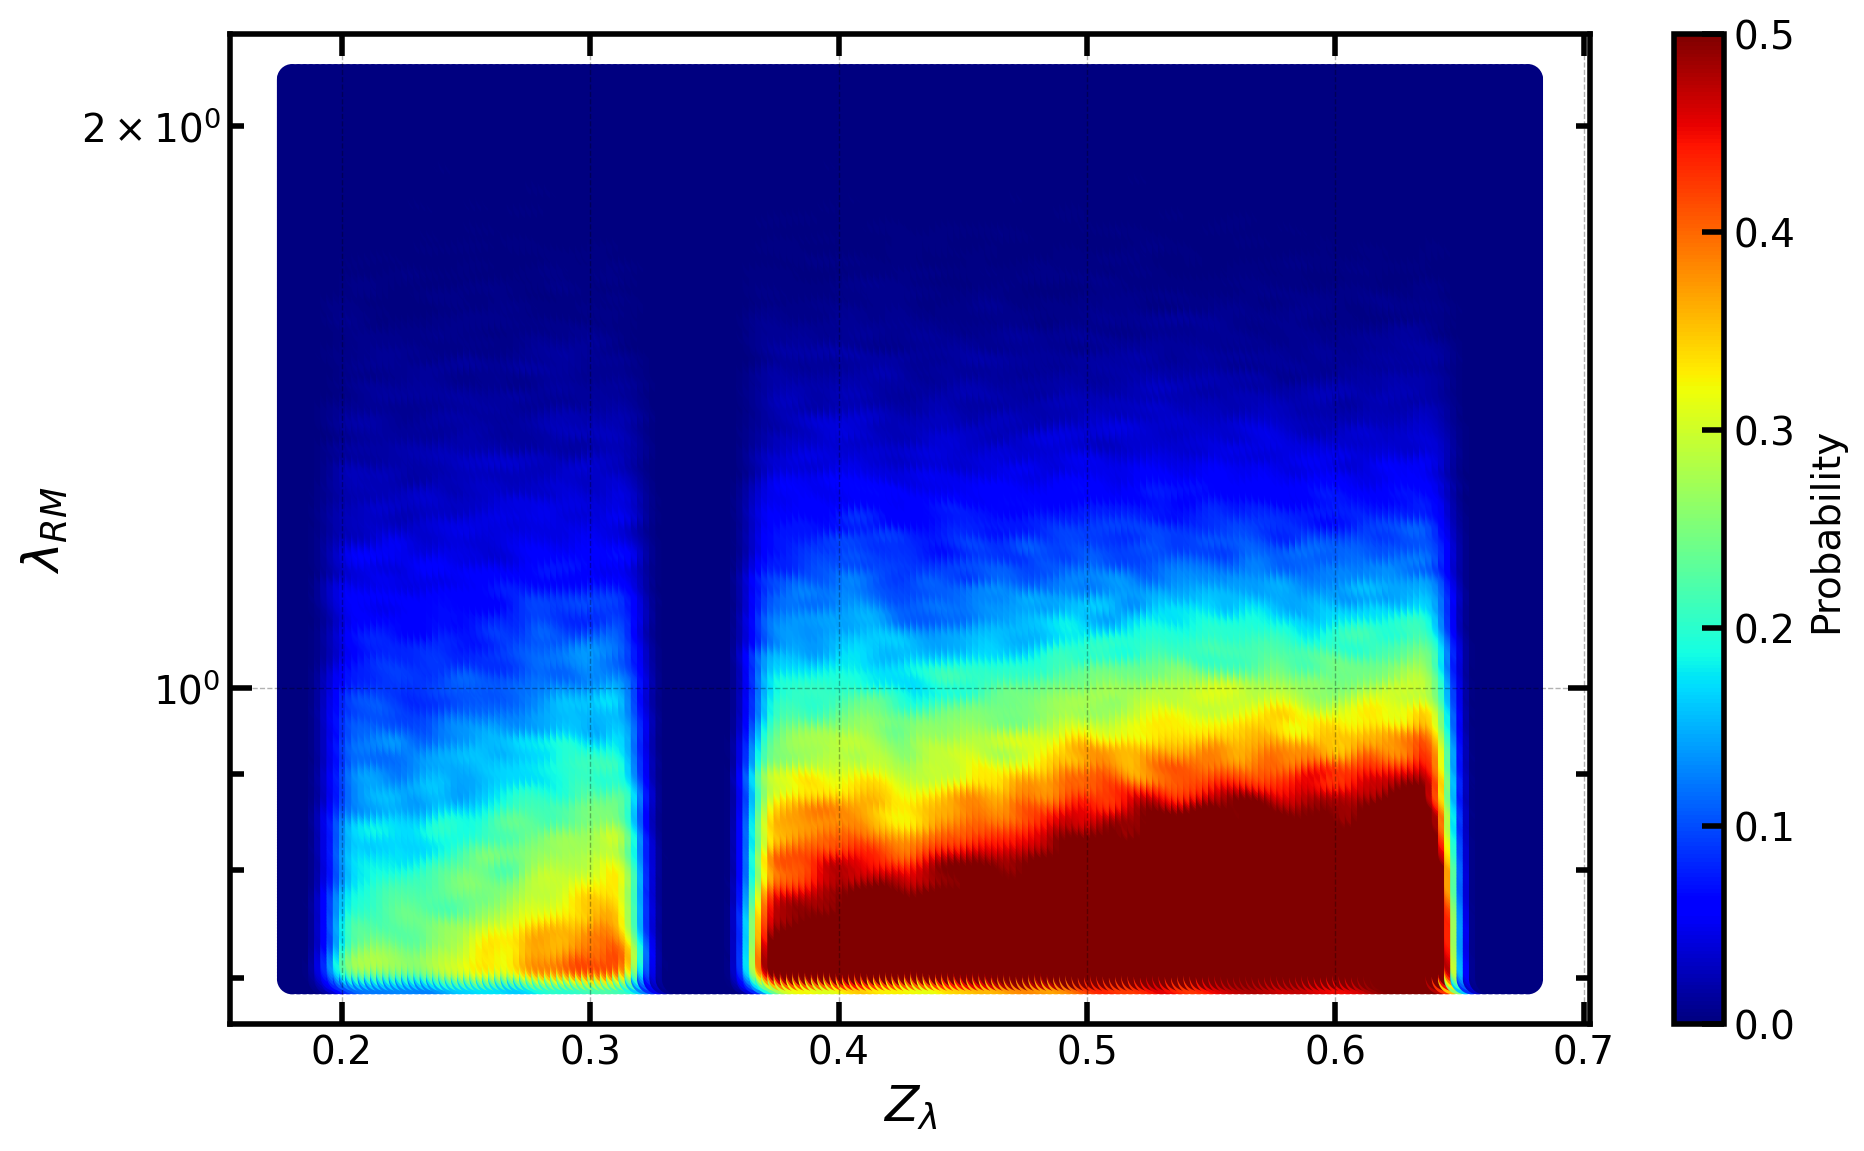

In [34]:
plt.figure(figsize=(10,6))
idx = np.argsort(prob[np.random.randint(len(zcls), size=Np)])
plt.scatter(zz.flatten(),ll.flatten(),c=p,vmax=0.5,cmap='jet')
plt.colorbar().set_label('Probability',fontsize=14)
plt.yscale('log')
plt.ylabel(r'$\lambda_{RM}$', fontsize=18)
plt.xlabel(r'$Z_{\lambda}$', fontsize=18)
plt.tight_layout()


In [35]:
pr = p.reshape(zbins.size, log_lbd_vec.size)

(1, 6123595.6604263)

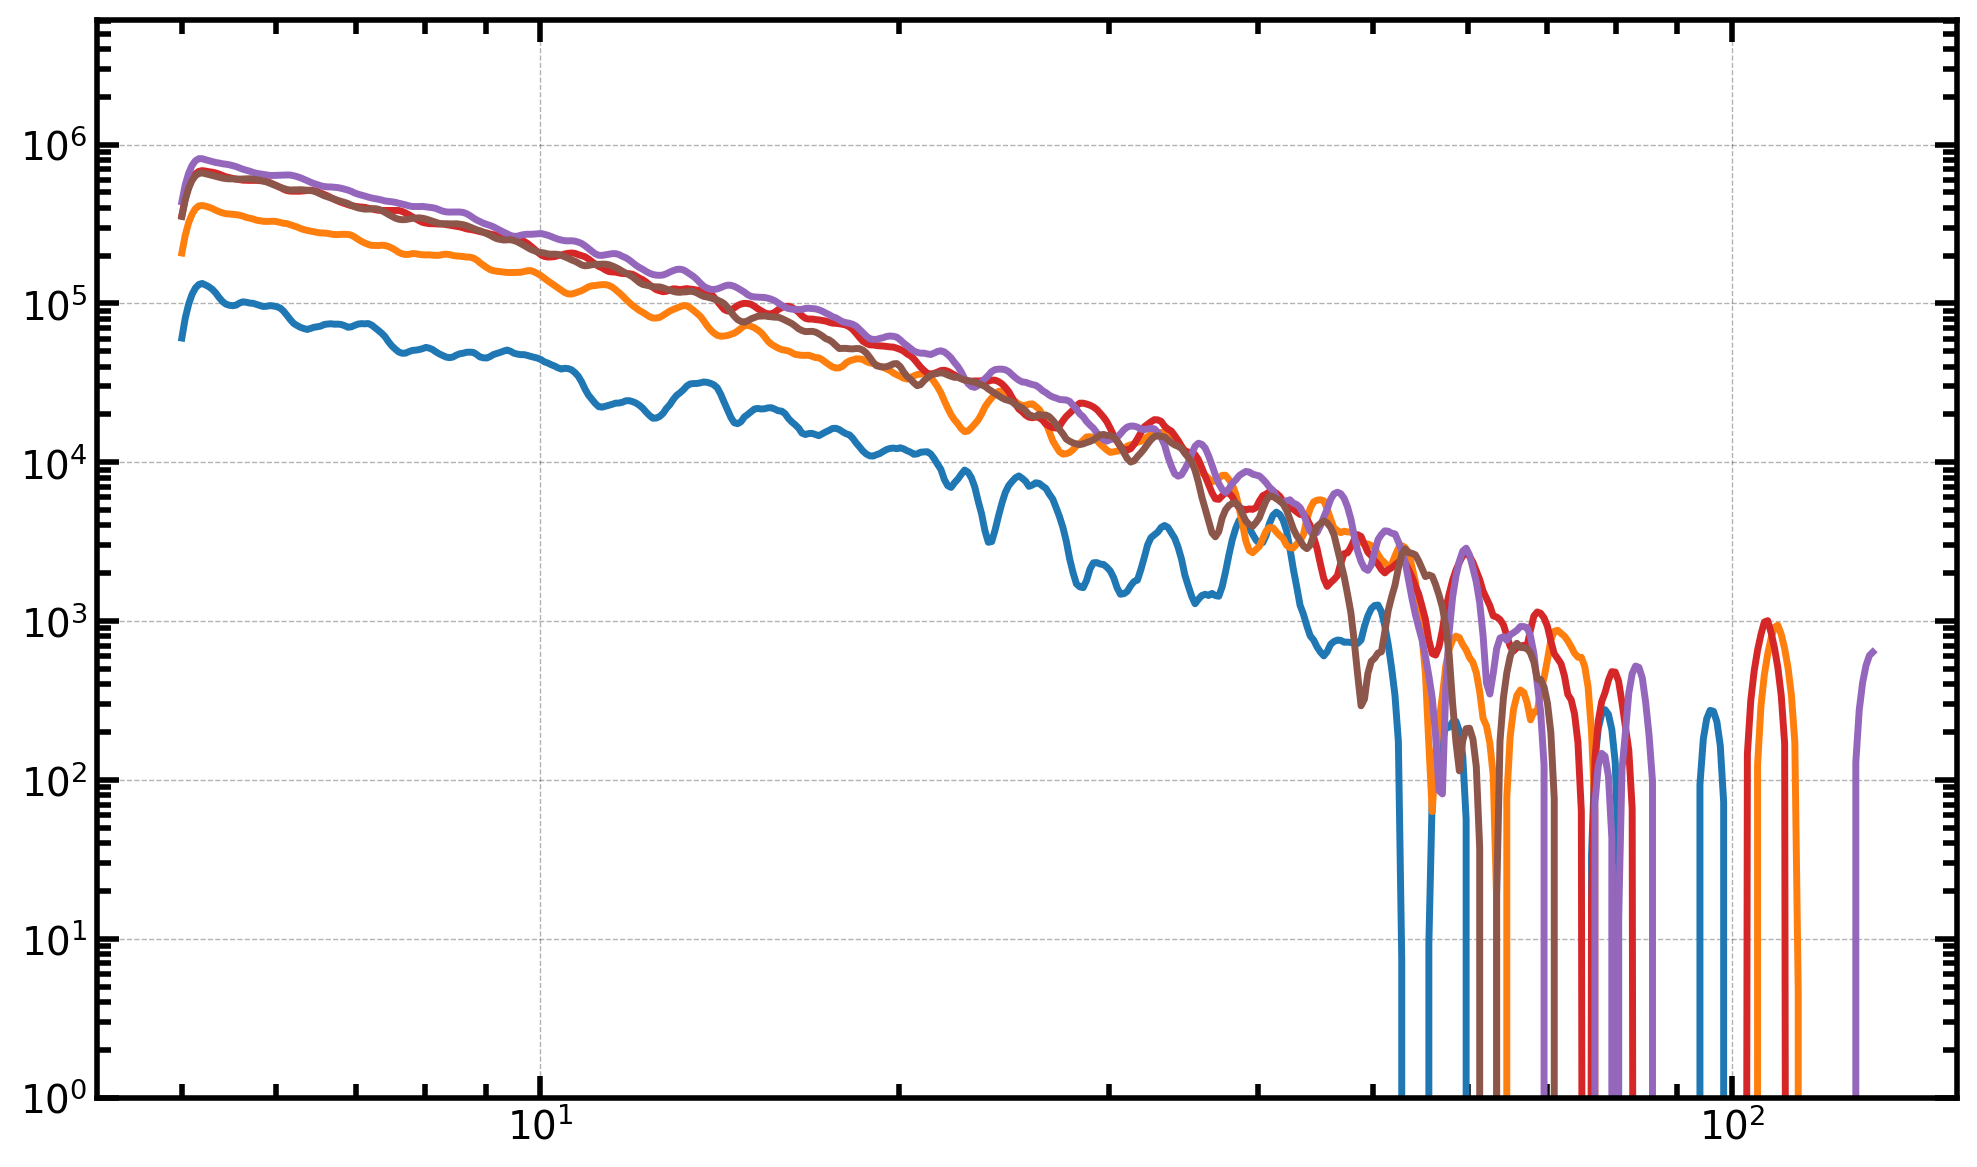

In [36]:
plt.loglog()
for zfix in [0.2, 0.3, 0.35, 0.46, 0.51, 0.65]:
    zslice = np.interp(zfix, zbins, np.arange(len(zbins))).astype(int)
    plt.plot(10**log_lbd_vec, 1e6*pr[zslice])
plt.ylim(1)

In [37]:
from scipy.interpolate import interp1d

lbd_vec = 10**log_lbd_vec

lbdnew = np.zeros_like(znew)
probnew = np.zeros_like(znew)
i = 0
for zmin,zmax in zip(zbins[:-1],zbins[1:]):
    zslice = np.where( (znew>=zmin)&(znew<zmax) )[0]
    nsize = zslice.size
    if nsize>0:
        pz = np.where(np.isnan(pr[i]), 0., pr[i])
        pz = pz/np.sum(pz)
        lbdnew[zslice] = np.random.choice(lbd_vec, nsize, p=pz)
        probnew[zslice] = np.interp(np.log10(lbdnew[zslice]), log_lbd_vec, pz)
    i += 1
    
probnew /= np.max(probnew)

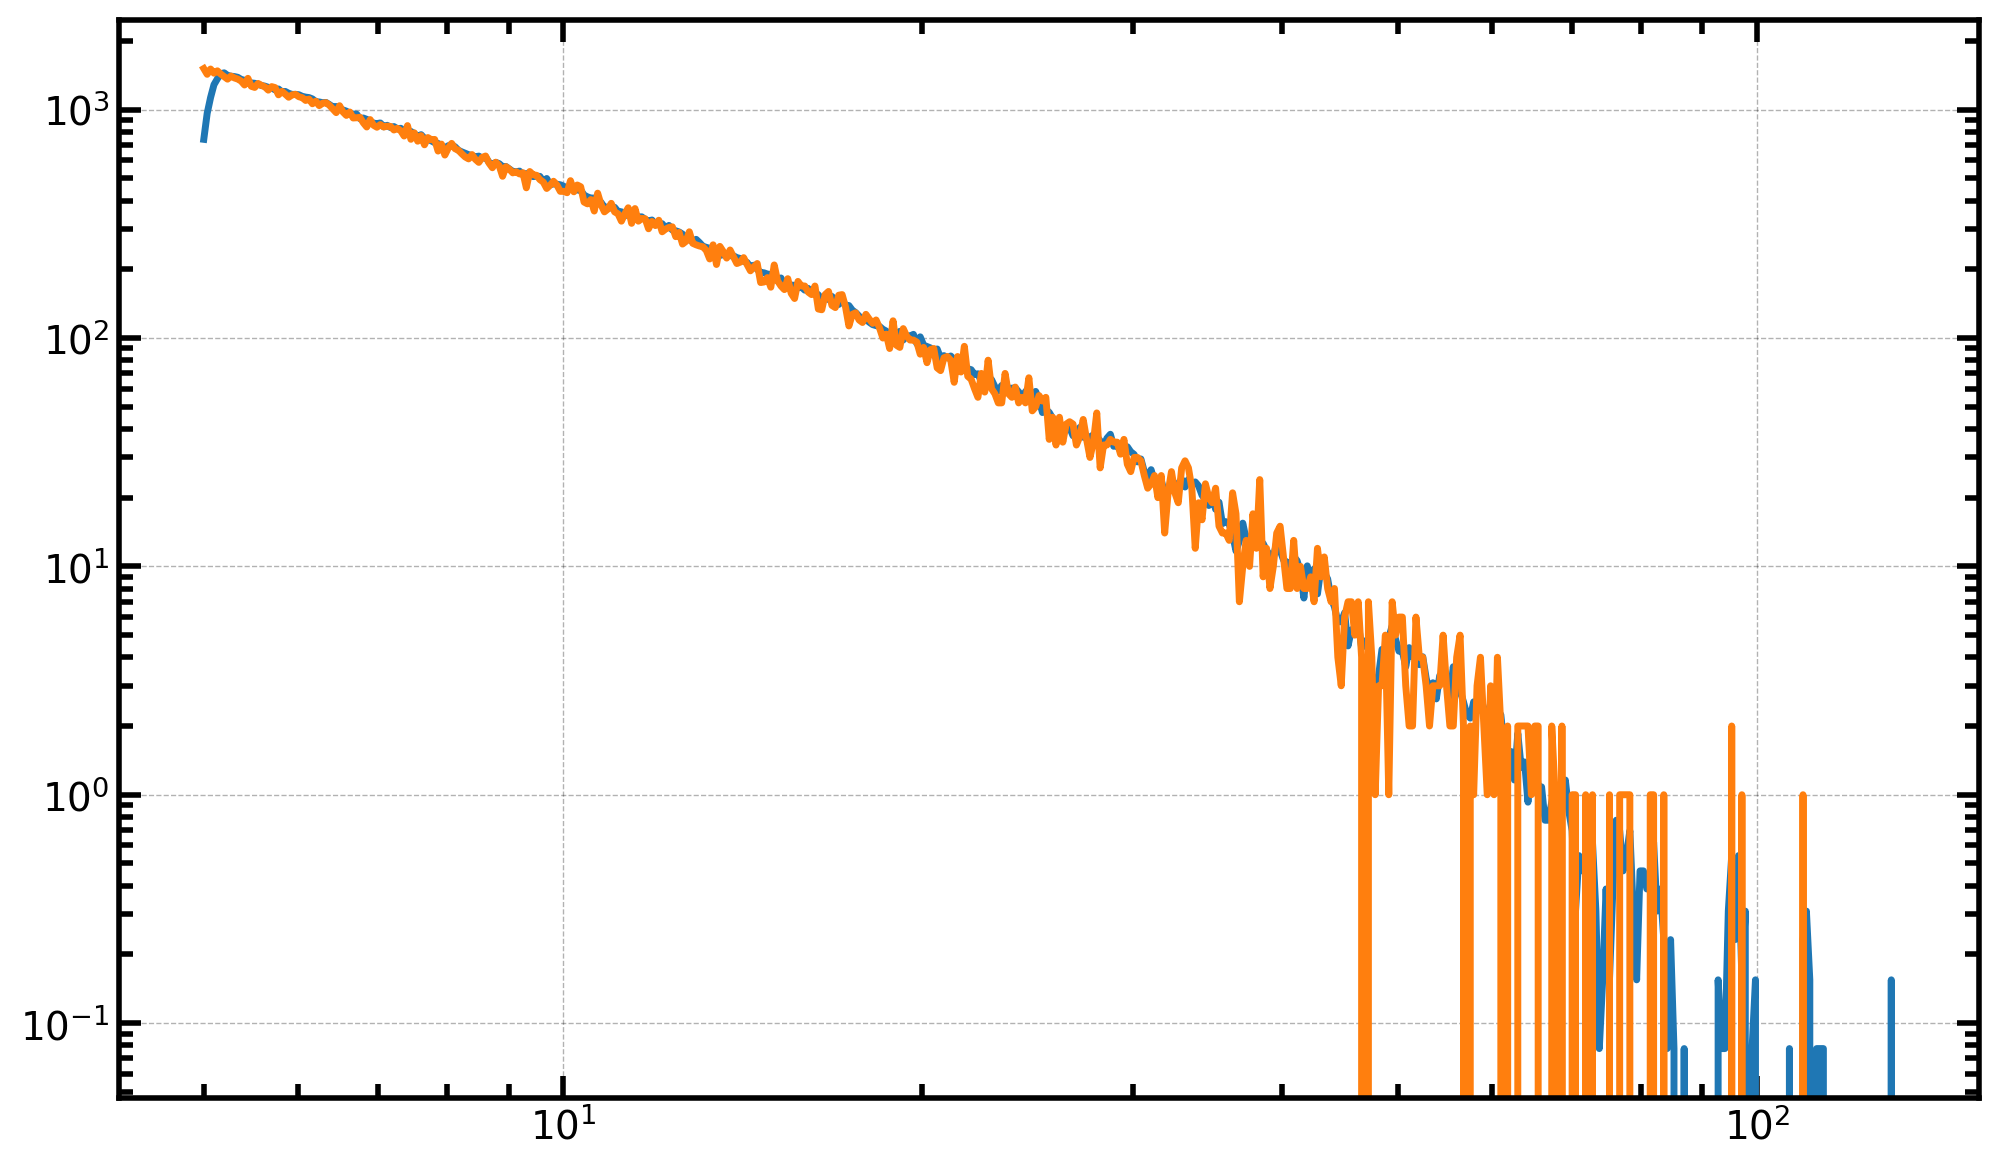

In [38]:
plt.loglog()

zmin, zmax = 0.51, 0.65

w1, = np.where((zcls>=zmin)&(zcls<=zmax))
w2, = np.where((znew>=zmin)&(znew<=zmax))

lbd_hist_ran, lmean = np.histogram(lbdnew[w2], lbd_vec)
lbd_hist, lmean = np.histogram(lbd[w1], lbd_vec)

plt.plot(lmean[:-1], alpha*lbd_hist_ran)
plt.plot(lmean[:-1], lbd_hist)

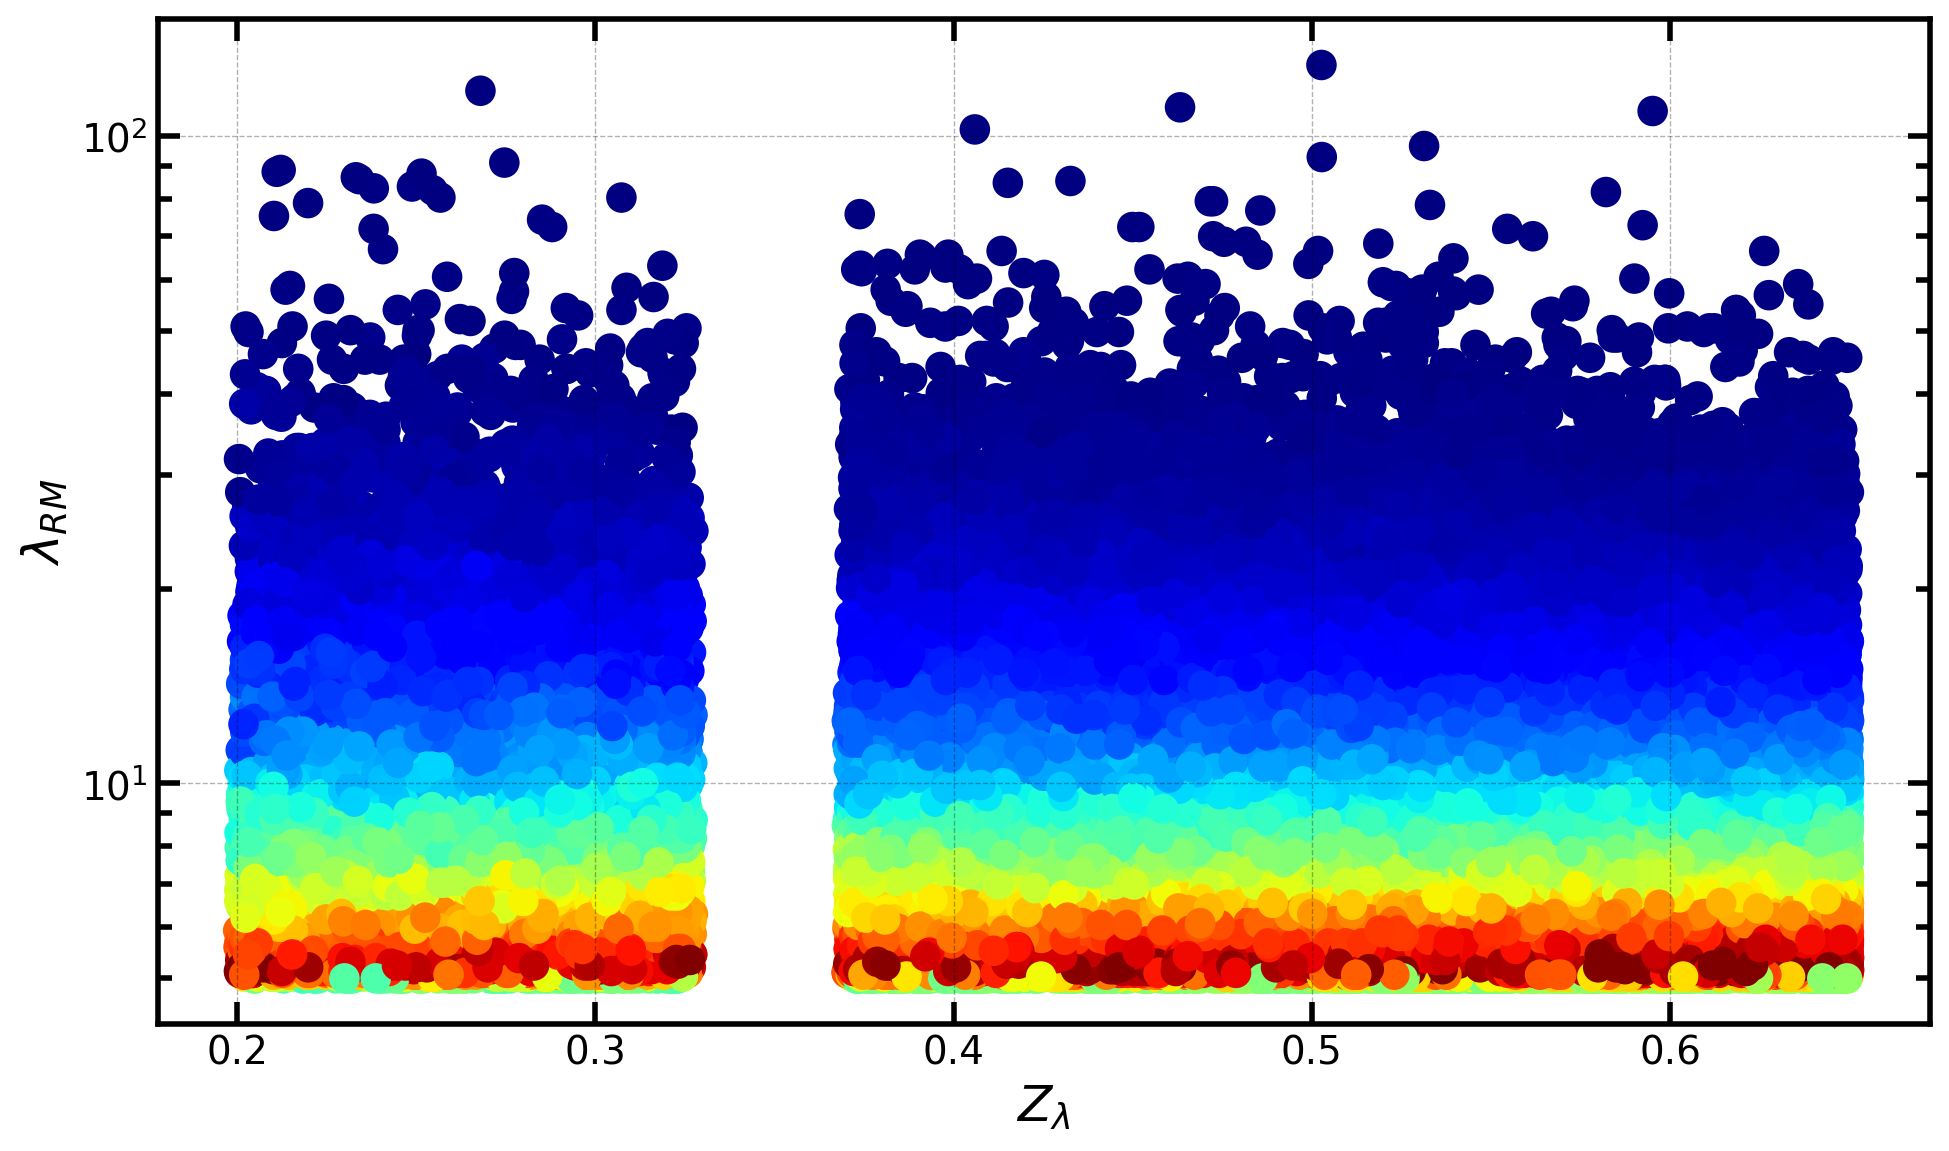

In [41]:
Np = 100000

plt.figure(figsize=(10,6))
idx = np.argsort(probnew[np.random.randint(len(znew), size=Np)])
plt.scatter(znew[idx],lbdnew[idx], c=probnew[idx],vmax=0.9,cmap='jet')
# plt.hexbin(zcls, lbd, yscale='log', gridsize=(50, 10))
# plt.xlabel(xlabel,fontsize=20)
# plt.ylabel(ylabel,fontsize=20)
# plt.colorbar().set_label('Probability',fontsize=14)
# plt.title('RM Y3 - Volume Limited',fontsize=20)
plt.yscale('log')
plt.ylabel(r'$\lambda_{RM}$', fontsize=18)
plt.xlabel(r'$Z_{\lambda}$', fontsize=18)
plt.tight_layout()
# plt.savefig('lambda_redshift_prob_sz.png',dpi=100, facecolor='w', transparent=False)

## Save

In [42]:
from astropy.table import Table

rand = Table()
rand['ra'] = np.array(randoms['ra'])
rand['dec'] = np.array(randoms['dec'])
rand['z'] = np.array(randoms['z'])
rand['lambda_mor'] = lbdnew

# rand['weight'] = np.array(randoms['weight'])
# rand['avg_lambdaout'] = np.array(randoms['avg_lambdaout'])

rand.write(floc.mock_random_fname, overwrite=True)
print('Saved file: %s'%floc.mock_random_fname)

Saved file: /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/mock_buzzard_like_y3_v0_randoms.fits


In [59]:
fname_out = './'+'mock_%s_box%05d.npz'

In [60]:
for i in range(3):
    print(fname_out%('t', i))

./mock_t_box00000.npz
./mock_t_box00001.npz
./mock_t_box00002.npz
